# 03 - Data Preparation - Features Creation
* (1) Create feature file in a DataFrame and CSV formats
    * Here I will only show a simple version of features file, that includes:
    * Row: subject_id, activity, event_num, walk_or_not, unique_id, time_s, la_x, la_y, la_z, fea_1, fea_2, ..., fea_1_norm, fea_2_norm, fea_3_norm, ... 
      - For Activity, it will include the following activity as True Positive and True Negative events:
        - True Positive (Walking): 1=walking; 2=descending stairs; 3=ascending stairs; 
        - True Negative (Non-Walking): 4=driving; 77=clapping; 99=non-study activity
    * The default data length for eash event will be 10-sec

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from constants import Constants

In [34]:
'''
* (1) Load functions and default setting variables by using *utils.py* and *constants.py* files
'''
# Get a list of all accelerometer files
all_files = utils.get_all_files()

# Setup paramters
fs = Constants.fs

In [39]:
'''
(1) Create feature file in a DataFrame and CSV formats
'''

# Load one accelerometer data file into dataframe
load_id = 0     # Load the first CSV file from the file list 
file_id, df = utils.load_single_data(all_files, load_id)
subject_id = file_id.split('/')[-1].split('.')[0]
print('Begin to convert acc dataframe for Subject='+file_id)

# General setting
location_id = ['la']
win_length = 6  # default will be 10-sec for each event
win_shift = 3  # No overlapping between each event 
acc_inputs = ['la_x', 'la_y', 'la_z']   # Only select Left-Ankle for now
activities = [1, 2, 3, 4, 77, 99]       # All 6 activities with annotations
activities_TP = [1, 2, 3]               # 1=walking; 2=descending stairs; 3=ascending stairs;
activities_TN = [4, 77, 99]             # 4=driving; 77=clapping; 99=non-study activity;

# Create an empty dataframe with defaulted column names 
columns_features = ['subject_id', 'device_loc', 'act_id', 'act_name', 'event_num', 'walk_or_not', 'unique_id', 'time', 'acc_x', 'acc_y', 'acc_z']
df_fea_all = pd.DataFrame(columns=columns_features)

device_loc = utils.get_device_location_for_df(location_id[0])

for activity in activities:
    # create a temporal dataframe 
    df_fea_layer_1 = pd.DataFrame(columns=columns_features)
    
    df_act = df[df.activity==activity]
    act_id = activity
    act_name = utils.get_activity_type_for_df(activity)

    # Begin to cut data into several 10-sec events
    total_segments_sec = round( (df_act.time_s.iloc[-1]-df_act.time_s.iloc[0]) / ( win_length-(win_length-win_shift) ) )  # compute how many segmnets in second will be cut
    for count, num in enumerate(range(0, total_segments_sec), start=1):
        df_fea_layer_2 = pd.DataFrame(columns=columns_features)
        
        cut_begin = df_act.time_s.iloc[0] + num*win_length
        cut_end   = cut_begin + win_length 
        df_cut_tmp = df_act[(df_act.time_s>=cut_begin) & (df_act.time_s<=cut_end)]
        
        # Write values into a temporal feature dataframe
        if df_cut_tmp.empty:
            df_fea_layer_2 = pd.DataFrame(columns=columns_features)  # If no values within the cut datafrmae
        else:
            if (df_cut_tmp.time_s.iloc[-1]-df_cut_tmp.time_s.iloc[0]) < win_length*0.9: 
                # apply quality control to make sure the segment does not include missing data
                # If the segment length is less than 90% of the target time window (9 sec in this case), discard this segment. 
                df_fea_layer_2 = pd.DataFrame(columns=columns_features)
            else:
                # Write the cut dataframe into a temporal feature dataframe
                df_fea_layer_2['time'] = df_cut_tmp['time_s']
                df_fea_layer_2['acc_x'] = df_cut_tmp['la_x']
                df_fea_layer_2['acc_y'] = df_cut_tmp['la_y']
                df_fea_layer_2['acc_z'] = df_cut_tmp['la_z']
        
                # Write others values into the temporal feature dataframe 
                df_fea_layer_2['subject_id'] = subject_id
                df_fea_layer_2['device_loc'] = device_loc
                df_fea_layer_2['act_id'] = act_id
                df_fea_layer_2['act_name'] = act_name
                df_fea_layer_2['event_num'] = count

                unique_id_template = subject_id+'_'+device_loc+'_'+str(activity)+'_'+act_name+'_'+str(count)
                if activity in activities_TP:
                    df_fea_layer_2['walk_or_not'] = 1
                    df_fea_layer_2['unique_id'] = unique_id_template + '_1'
                elif activity in activities_TN:
                    df_fea_layer_2['walk_or_not'] = 0
                    df_fea_layer_2['unique_id'] = unique_id_template + '_0'
                
        # Reset dataframe index
        df_fea_layer_2 = df_fea_layer_2.reset_index(drop=True)

        # Concat each 10-sec dataframe into a larger dataframe
        df_fea_layer_1 = pd.concat([df_fea_layer_1, df_fea_layer_2])
        df_fea_layer_1 = df_fea_layer_1.reset_index(drop=True)
        
    # Concat all dataframes into one big final dataframe
    df_fea_all = pd.concat([df_fea_all, df_fea_layer_1])
    df_fea_all = df_fea_all.reset_index(drop=True)    

# # Save the output dataframe to a parquet format (to save up to 90% of space)
df_fea_all.to_parquet('../outputs/df_acc_la_'+subject_id+'.parquet')
df_fea_all.to_csv('../outputs/df_acc_la_'+subject_id+'.csv')
print('Completed converting')

Begin to convert acc dataframe for Subject=../data/raw_accelerometry_data/idf1ce9a0f.csv
Completed converting


In [40]:
'''
Show statistic of the features file for the first subject
'''
df = pd.read_parquet('../outputs/df_acc_la_idf1ce9a0f.parquet')
print(np.unique(df.act_name))
df

['AscendStairs' 'DescStairs' 'Driving' 'NonStudyAct' 'Walking']


,subject_id,device_loc,act_id,act_name,event_num,walk_or_not,unique_id,time,acc_x,acc_y,acc_z
0,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.05,-0.070,-0.973,0.078
1,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.06,-0.082,-0.965,0.094
2,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.07,-0.082,-0.969,0.086
3,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.08,-0.082,-0.973,0.086
4,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.09,-0.098,-0.969,0.105
...,...,...,...,...,...,...,...,...,...,...,...
315181,idf1ce9a0f,AnkleL,99,NonStudyAct,547,0,idf1ce9a0f_AnkleL_99_NonStudyAct_547_0,3281.97,-0.055,0.039,0.996
315182,idf1ce9a0f,AnkleL,99,NonStudyAct,547,0,idf1ce9a0f_AnkleL_99_NonStudyAct_547_0,3281.98,-0.055,0.039,0.992
315183,idf1ce9a0f,AnkleL,99,NonStudyAct,547,0,idf1ce9a0f_AnkleL_99_NonStudyAct_547_0,3281.99,-0.059,0.035,0.988
315184,idf1ce9a0f,AnkleL,99,NonStudyAct,547,0,idf1ce9a0f_AnkleL_99_NonStudyAct_547_0,3282.00,-0.063,0.039,0.992


Subject id=idf1ce9a0f
Total Walking events= 98
Total Non-Walking events= 427
Non-Walking/Walking Ratio= 4.357142857142857


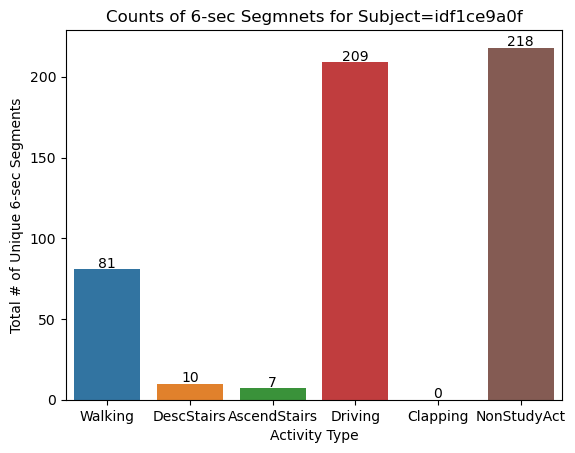

In [49]:
total_events = len(np.unique(df.unique_id))

total_Walking = len(np.unique(df[df.act_id==1].unique_id))
total_DescStairs = len(np.unique(df[df.act_id==2].unique_id))
total_AscendStairs = len(np.unique(df[df.act_id==3].unique_id))
total_Driving = len(np.unique(df[df.act_id==4].unique_id))
total_Clapping = len(np.unique(df[df.act_id==77].unique_id))
total_NonStudyAct = len(np.unique(df[df.act_id==99].unique_id))

act_type = ['Walking', 'DescStairs', 'AscendStairs', 'Driving', 'Clapping', 'NonStudyAct']
total_num = [total_Walking, total_DescStairs, total_AscendStairs, total_Driving, total_Clapping, total_NonStudyAct]

sns.barplot(x=act_type, y=total_num)
plt.xlabel('Activity Type')
plt.ylabel('Total # of Unique 6-sec Segments')
plt.title('Counts of 6-sec Segmnets for Subject='+subject_id)

for i in range(len(act_type)):
    plt.text(x=i, y=total_num[i] + 1, s=total_num[i], ha='center')

print("Subject id="+subject_id)
print("Total Walking events=", (total_Walking+total_DescStairs+total_AscendStairs))
print("Total Non-Walking events=", (total_Driving+total_Clapping+total_NonStudyAct))
print("Non-Walking/Walking Ratio=", (total_Driving+total_Clapping+total_NonStudyAct)/(total_Walking+total_DescStairs+total_AscendStairs))

Text(0.5, 1.0, 'Non-Study Activity (99) / 6-sec')

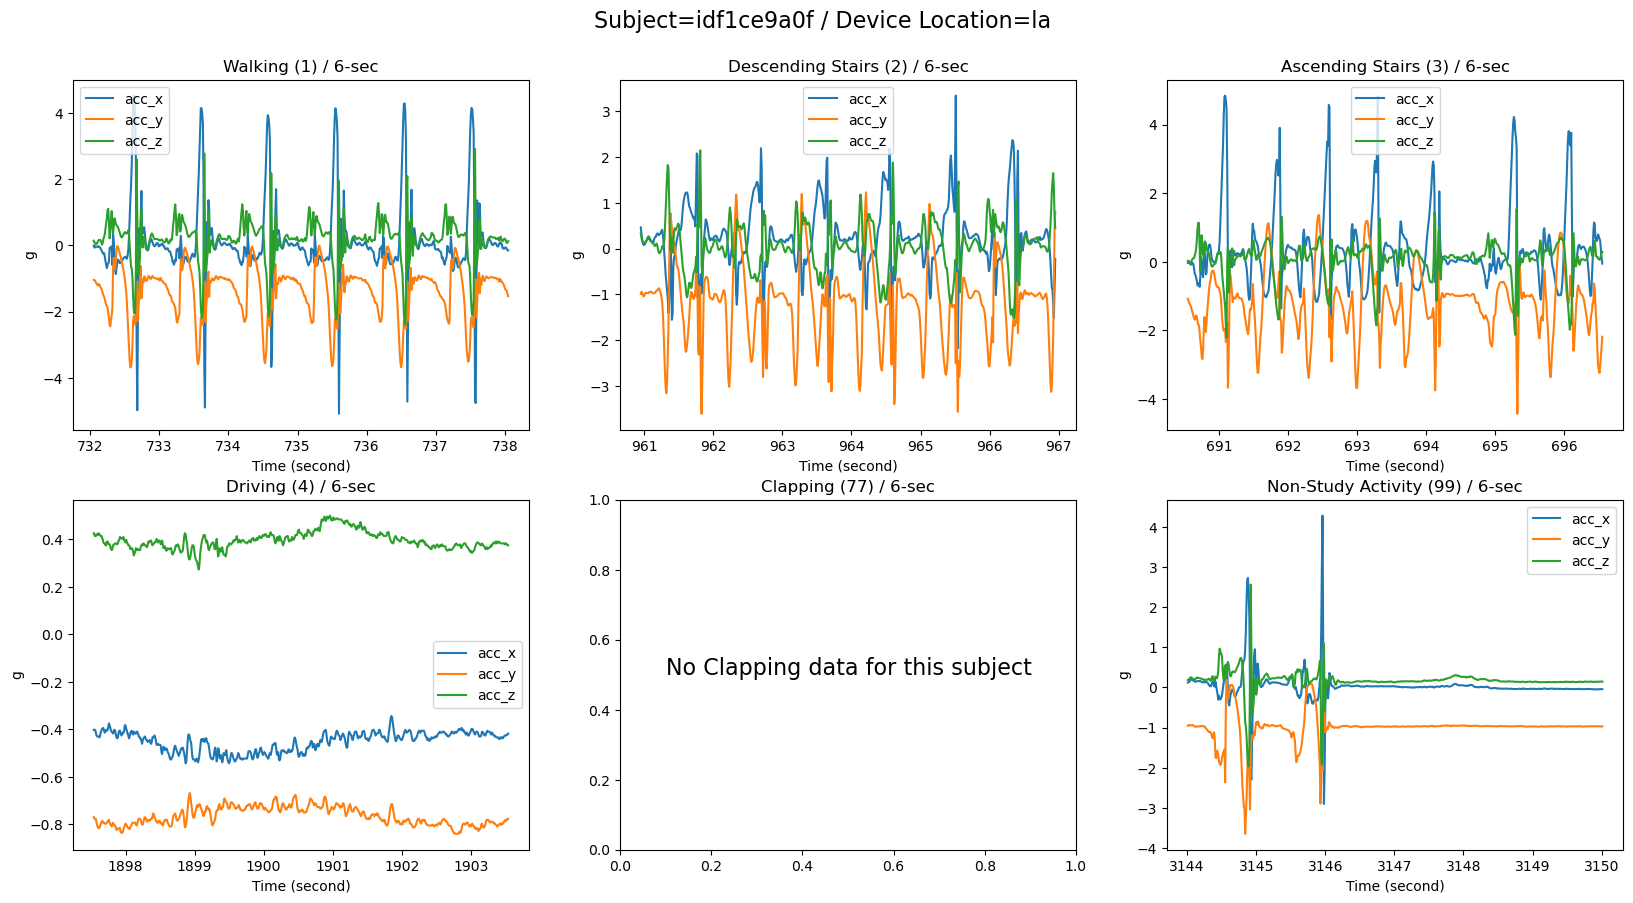

In [30]:
'''
Quality check with each type of activity from the 'df_acc' file 
'''

fig = plt.figure(figsize=(20, 10))

fig.suptitle('Subject='+df.subject_id.iloc[0]+' / Device Location='+df.device_loc.iloc[0], fontsize=16, y=0.95)

def _plot(df2):
    plt.plot(df2.time, df2.x, label='acc_x')
    plt.plot(df2.time, df2.y, label='acc_y')
    plt.plot(df2.time, df2.z, label='acc_z')
    plt.legend()
    plt.xlabel('Time (second)')
    plt.ylabel('g')

plt.subplot(2,3,1)
df2 = df[(df.unique_id=='idf1ce9a0f_la_1_64_1')]
_plot(df2)
plt.title('Walking (1) / 6-sec')


plt.subplot(2,3,2)
df2 = df[(df.unique_id=='idf1ce9a0f_la_2_95_1')]
_plot(df2)
plt.title('Descending Stairs (2) / 6-sec')

plt.subplot(2,3,3)
df2 = df[(df.unique_id=='idf1ce9a0f_la_3_48_1')]
_plot(df2)
plt.title('Ascending Stairs (3) / 6-sec')


plt.subplot(2,3,4)
df2 = df[(df.unique_id=='idf1ce9a0f_la_4_87_0')]
_plot(df2)
plt.title('Driving (4) / 6-sec')


plt.subplot(2,3,5)
plt.text(0.1, 0.5, 'No Clapping data for this subject', fontsize=16)
plt.title('Clapping (77) / 6-sec')

plt.subplot(2,3,6)
df2 = df[(df.unique_id=='idf1ce9a0f_la_99_525_0')]
_plot(df2)
plt.title('Non-Study Activity (99) / 6-sec')

In [8]:
# Show all unique_event_id
np.unique(df.unique_id)

array(['idf1ce9a0f_1_107_1', 'idf1ce9a0f_1_108_1', 'idf1ce9a0f_1_109_1',
       'idf1ce9a0f_1_110_1', 'idf1ce9a0f_1_111_1', 'idf1ce9a0f_1_112_1',
       'idf1ce9a0f_1_113_1', 'idf1ce9a0f_1_114_1', 'idf1ce9a0f_1_115_1',
       'idf1ce9a0f_1_15_1', 'idf1ce9a0f_1_16_1', 'idf1ce9a0f_1_17_1',
       'idf1ce9a0f_1_18_1', 'idf1ce9a0f_1_19_1', 'idf1ce9a0f_1_1_1',
       'idf1ce9a0f_1_20_1', 'idf1ce9a0f_1_21_1', 'idf1ce9a0f_1_22_1',
       'idf1ce9a0f_1_23_1', 'idf1ce9a0f_1_24_1', 'idf1ce9a0f_1_25_1',
       'idf1ce9a0f_1_26_1', 'idf1ce9a0f_1_27_1', 'idf1ce9a0f_1_28_1',
       'idf1ce9a0f_1_29_1', 'idf1ce9a0f_1_2_1', 'idf1ce9a0f_1_30_1',
       'idf1ce9a0f_1_31_1', 'idf1ce9a0f_1_32_1', 'idf1ce9a0f_1_33_1',
       'idf1ce9a0f_1_34_1', 'idf1ce9a0f_1_35_1', 'idf1ce9a0f_1_36_1',
       'idf1ce9a0f_1_37_1', 'idf1ce9a0f_1_3_1', 'idf1ce9a0f_1_46_1',
       'idf1ce9a0f_1_47_1', 'idf1ce9a0f_1_48_1', 'idf1ce9a0f_1_49_1',
       'idf1ce9a0f_1_4_1', 'idf1ce9a0f_1_50_1', 'idf1ce9a0f_1_51_1',
       'idf1ce9